In [2]:
import networkx as nx
import numpy as np
import helper_functions as hf 
COLORS="brgymcbrgymc"

import importlib
importlib.reload(hf)

import problem as pr
importlib.reload(pr)

<module 'problem' from '/home/lema/Documents/diplomska/problem.py'>

[(1, 3), (3, 4), (3, 5), (2, 3), (4, 5), (5, 6), (5, 7)]
[[1. 1. 0. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]] [[1. 1. 0. 0.]
 [0. 0. 1. 1.]] [1, 1, 1, 1, 1, 1, 1] [1, 2, 1, 4, 5, 6, 7] [1, 1]
[(1, 3), (3, 5), (5, 6)]
[(1, 3), (3, 4), (4, 5), (5, 6)]
[(3, 5), (2, 3), (5, 7)]
[(3, 4), (2, 3), (4, 5), (5, 7)]


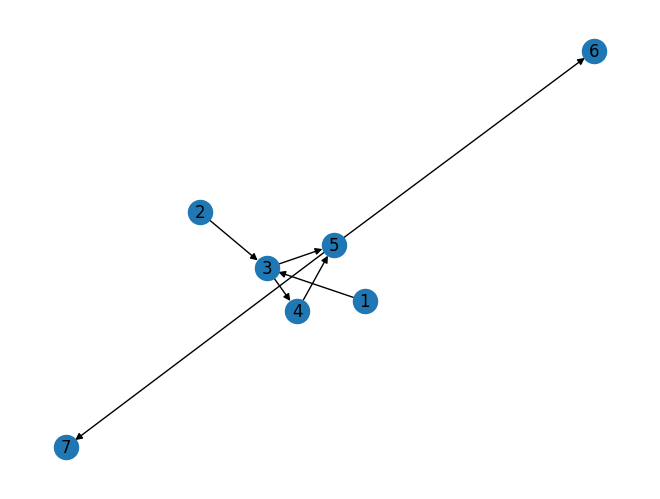

In [3]:

G = nx.DiGraph()
# G.add_edges_from([(1,3),(2,3),(3,4),(4,5),(3,5),(5,6),(5,7),(3,1),(3,2),(4,3),(5,4),(5,3),(6,5),(7,5)])
G.add_edges_from([(1,3),(2,3),(3,4),(4,5),(3,5),(5,6),(5,7)])


print(G.edges())
#nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, name = 'c')
nx.set_edge_attributes(G, {e: (i+1) for i,  e in enumerate(G.edges())}, name = 'c')
nx.set_edge_attributes(G, {(3,5):1}, name = 'c')
nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, name = 't')
x = list(G.edges)

nx.draw(G,with_labels=True)

ZK = [(1,6,1),(2,7,1)] # z,k,a

Q,B,t,c,a = hf.sestavi_QBtca(ZK, G)
print(Q,B,t,c,a)

for i in range(Q.shape[1]):
    print(hf.binary_vector_to_edges(Q[:,i],G.edges()))

        


In [17]:
# #c = [1, 3, 1, 1, 3, 1, 3]
# #t = [1, 1, 1, 1, 0.5, 1, 1]
# #Q = [[1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0], [1, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 0, 1, 1]]
# #B = [[1, 1, 0, 0], [0, 0, 1, 1]]


# paths = hf.poklici_linprog(ZK,G)


In [18]:
# paths = hf.poklici_linprog(ZK,G,edges_mode=True)
# hf.my_nx_draw(G,paths,with_labels=True,with_nodes=False)
# print(paths)

In [6]:
# problematicen je izbor zacetnega priblizka, vecinoma se zatekne v lokalnem minimumu
# kako vpeljat da gresta 2 avta po neki poti? TODO
# bolj pameten zacetni priblizek
import numpy as np
from scipy.optimize import minimize

# Definiramo funkcijo, ki jo želimo minimizirati
t = np.array([[1,1,30,1,1,1,1]]).T
c = np.array([[1,1,1,1,1,1,1]]).T * 2
ZK = [(1,6,1),(2,7,1)]
def poklici_minimize(ZK,c,t):
    M = hf.sparse_incidence_matrix(G.nodes(),G.edges())
    
    a = [a for _,_,a in ZK]
    M_ZK = hf.sparse_incidence_matrix(G.nodes(),[(z,k) for z, k, _ in ZK],factor=a)
    
    def f(x):
        X = x.reshape(len(t),len(ZK))
        return np.sum(t.T@X)

    # X0 = np.array([[1,0],[0,0],[1,1],[0,1],[0,0],[1,0],[0,1]])
    # x0 = X0.reshape(-1)
    x0 = np.random.rand(len(t) * len(ZK)) #* max(a)
    print(x0)

    # Definiramo omejitve, če so potrebne (npr. X mora biti pozitiven)
    #X >= 0

    constraints = []
    constraints =  [{'type': 'ineq', 'fun': lambda x: x}]
    def con1(x):
        X = x.reshape(len(t),len(ZK))
        m = len(ZK)
        unit = np.ones((m, 1))
        r = c - X@unit
        return np.repeat(r,x.size//r.size)
    constraints.append({'type': 'ineq', 'fun': con1})
    def con2(x):
        X = x.reshape(len(t),len(ZK))
        r = M@X - M_ZK
        r = r.reshape(-1)
        return np.repeat(r,x.size//r.size)
    constraints.append({'type': 'eq', 'fun': con2})
    print(constraints)
    res = minimize(f, x0, method='SLSQP', constraints=constraints, bounds=np.array((np.zeros(x0.size),np.ones(x0.size))).T)

    # Izpišemo optimalno rešitev
    print('(NE)Optimalna rešitev:')
    print(res.x, res.fun, res.message, res.success)


    def smart_round(x):
        x[x > 0.5] = 1
        x[x < 0.5] = 0
        return x
    round_x = smart_round(res.x)
    print(round_x)
    print(f(round_x))

poklici_minimize(ZK,c,t)

[0.00245789 0.51012494 0.95426733 0.24833514 0.26008328 0.59861118
 0.18938743 0.01276903 0.76141224 0.39070145 0.11095105 0.1025378
 0.26929279 0.06080584]
[{'type': 'ineq', 'fun': <function poklici_minimize.<locals>.<lambda> at 0x7fbd5c0e4ca0>}, {'type': 'ineq', 'fun': <function poklici_minimize.<locals>.con1 at 0x7fbcf53b3490>}, {'type': 'eq', 'fun': <function poklici_minimize.<locals>.con2 at 0x7fbcf53b3eb0>}]
(NE)Optimalna rešitev:
[1.        0.        1.        0.6354836 0.        0.3645164 0.
 1.        1.        0.6354836 1.        0.        0.        1.       ] 18.206459074874914 Optimization terminated successfully True
[1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1.]
8.0


In [23]:
G.edges()

OutEdgeView([(1, 3), (3, 4), (3, 5), (2, 3), (4, 5), (5, 6), (5, 7)])

In [19]:
# ZK = [(1,6,1),(2,7,1)]
# t = np.array([1,1,30,1,1,1,1])
# c = np.array([1,1,1,1,1,1,1]) * 2
# f,B,c,M2,m_ZK = hf.nastavi_fbcmm(G,ZK,c,t)
# print(f,B,c,M2,m_ZK)

In [20]:
# from scipy.optimize import linprog
# #print(f,B,c,M2.todense(),m_ZK)
# res = linprog(f, A_ub=B, b_ub=c, A_eq=M2, b_eq=m_ZK, integrality=1)
# print(res.x,res.fun,res.message)

In [16]:
# # p = pr.Problem(None, G, ZK = None, ZK_shape=(2,2), c_mode = 2, t_mode= 2)
# p = pr.Problem(None, G, ZK = ZK, ZK_shape=None, c_mode = None, c = c, t_mode= None, t=t)
# p.solve(mode="linprog_v1")

In [7]:
G.edges()

OutEdgeView([(1, 3), (3, 4), (3, 5), (2, 3), (4, 5), (5, 6), (5, 7)])

f_c_sums:  0 0.0
<class 'problem.Linprog_v1'>:
36.0 Optimization terminated successfully. (HiGHS Status 7: Optimal) True


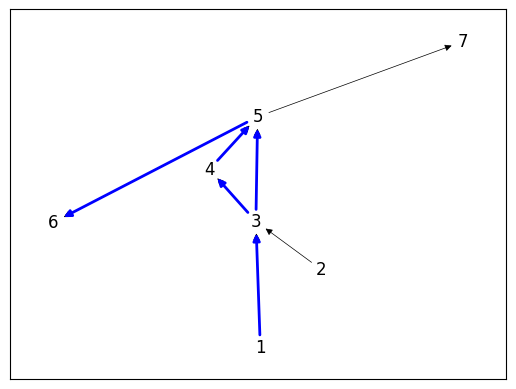

<class 'problem.Lingen'>:
36.0 glej success True


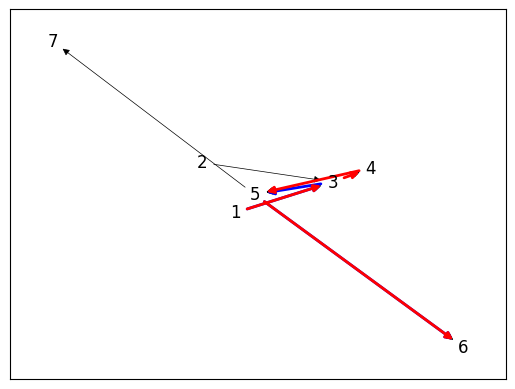

In [23]:
importlib.reload(pr)
ZK = [(1,6,2)]
c = [2,1,1,1,1,2,1]
p = pr.Problem(None, G, ZK = ZK, ZK_shape=None, c_mode = None, c = c, t_mode= None, t=t)
pr.Linprog_v1.solve(p)

pr.Lingen.solve(p)
#pr.Linmin.solve(p)
pr.Problem.draw(p)

<class 'problem.Linprog_v1'>:
Optimization terminated successfully. (HiGHS Status 7: Optimal) 8.0 True
<class 'problem.Linprog_v1'>:
8.0 Optimization terminated successfully. (HiGHS Status 7: Optimal) True


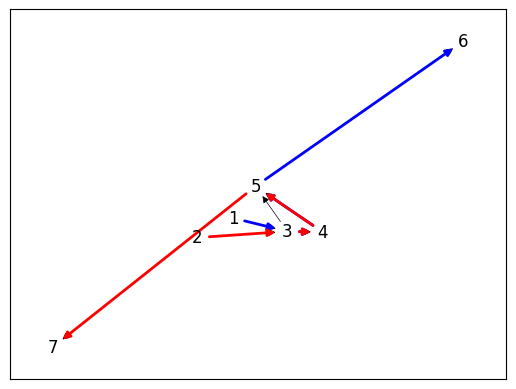

In [24]:
importlib.reload(pr)
t = [1,1,30,1,1,1,1]
# c = [1,1,1,1,1,1,1]
#c = [2,2,2,2,2,2,2]
ZK = [(1,6,1),(2,7,1)]
p = pr.Problem(None, G, ZK = ZK, ZK_shape=None, c_mode = 2, c = None, t_mode= None, t=list(t))
pr.Linprog_v1.solve(p)
#pr.Lingen.solve(p,num_iter=100)
pr.Problem.print(p)
pr.Problem.draw(p)

In [40]:
print(p.g.edges())
p.results


[(1, 3), (3, 4), (3, 5), (2, 3), (4, 5), (5, 6), (5, 7)]


{"<class 'problem.Linprog_v1'>": {'X': array([[1., 0.],
         [1., 1.],
         [0., 0.],
         [0., 1.],
         [1., 1.],
         [1., 0.],
         [0., 1.]]),
  'fun': 8.0,
  'message': 'Optimization terminated successfully. (HiGHS Status 7: Optimal)',
  'success': True,
  'paths': [[1, 3, 4, 5, 6], [2, 3, 4, 5, 7]]},
 "<class 'problem.Lingen'>": {'X': array([[1., 0.],
         [1., 1.],
         [0., 0.],
         [0., 1.],
         [1., 1.],
         [1., 0.],
         [0., 1.]]),
  'fun': 8.0,
  'message': 'glej success',
  'success': True,
  'paths': [[1, 3, 4, 5, 6], [2, 3, 4, 5, 7]]}}

<class 'problem.Greedy'>:
glej success 8.0 True
<class 'problem.Greedy'>:
8.0 glej success True


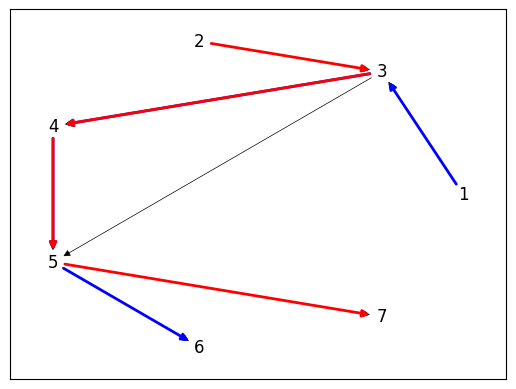

In [4]:
importlib.reload(pr)
t = [1,1,30,1,1,1,1]
ZK = [(1,6,1),(2,7,1)]
p = pr.Problem(None, G, ZK = ZK, ZK_shape=None, c_mode = 2, c = None, t_mode= None, t=list(t))
pr.Greedy.solve(p)
pr.Problem.print(p)
pr.Problem.draw(p)